# Output summaries of datatset 

I need to get a handle on how many full genomes I have from different countries, domestic/wild statuses, etc... I can sort of get an idea of this by looking at the tree, but it would be good to have some actual numbers. In this notebook, I would like to do the following: 

1. group strains to select out ones that have full genomes vs. do not. 
2. plot the distribution of genomes from domestic and wild birds for different geographic areas

In [1]:
# using the Entrez feature from bio
from Bio import SeqIO
import re
import time, datetime
import pandas as pd 
import numpy as np
import rpy2
%load_ext rpy2.ipython

# Read in full genomes metadata files

I have subsetted down my data to include only full genome sequences. I would now like to read in those files and output some summary statistics about our representation of geographic region, host species, and time

In [2]:
h5n1_clades_file = "/Users/lmoncla/src/avian-flu/clade-labeling/h5n1-clades.tsv"

In [3]:
# condense clades into groups
clade_mapping = {
"0":"0",
 
"1":"1",
"1.1":"1",
"1.1-like":"1",
"1.1.1":"1",
"1.1.2":"1",
 
"2.1":"2.1",
"2-like":"2.1",
"2.1.1":"2.1",
"2.1.2":"2.1",
"2.1.3":"2.1",
"2.1.3.1":"2.1",
"2.1.3.2":"2.1",
"2.1.3.2a":"2.1",
"2.1.3.2b":"2.1",
"2.1.3.3":"2.1",
 
"2.2":"2.2",
"2.2.1":"2.2",
"2.2.1.1":"2.2",
"2.2.1.1a":"2.2",
"2.2.1.2":"2.2",
"2.2.2":"2.2",
"2.2.2.1":"2.2",
 
"2.3":"2.3",
"2.3.1":"2.3",
"2.3.2":"2.3",
"2.3.2.1":"2.3",
"2.3.2.1a":"2.3",
"2.3.2.1b":"2.3",
"2.3.2.1c":"2.3",
"2.3.3":"2.3",
                 
"2.3.4":"2.3.4",
"2.3.4-like":"2.3.4",
"2.3.4.1":"2.3.4",
"2.3.4.2":"2.3.4",
"2.3.4.3":"2.3.4",
"2.3.4.4":"2.3.4",
 
"2.4":"other",
"2.5":"other",
"3":"other",
"3-like":"other",
"4":"other",
"5":"other",
"5-6-like":"other",
"6":"other",
"7":"other",
"7.1":"other",
"7.2":"other",
"8":"other",
"8-9-like":"other",
"9":"other",
"EA-nonGsGD":"non-GsGd",
"Am-nonGsGD":"non-GsGd",
"1-8-9-like":"other",
"?":"unknown"}

In [4]:
h5n1_clades_dict = {}

with open(h5n1_clades_file, "r") as infile: 
    for line in infile: 
        strain = line.split("\t")[0]
        clade = line.split("\t")[1].strip()
        h5n1_clades_dict[strain] = clade
        
#print(h5n1_clades_dict)

In [5]:
def read_metadata_file(metadata_file, output_dict, h5n1_clades_dict, clade_mapping):

    with open(metadata_file, "r") as infile: 
        for line in infile: 
            if "originating_lab" not in line:
                strain = line.split("\t")[0]
                accession = line.split("\t")[2]
                date = line.split("\t")[3]
                region = line.split("\t")[4]
                country = line.split("\t")[5]
                host_group = line.split("\t")[8].lower()
                domestic_wild = line.split("\t")[13]
                annotation_method = line.split("\t")[14]
                genbank_id = line.split("\t")[15]
                
                if strain in h5n1_clades_dict:
                    clade = h5n1_clades_dict[strain]
                    clade_group = clade_mapping[clade]
                else:
                    clade = "?"
                    clade_group = "unknown"
                
                if strain not in output_dict:
                    output_dict[strain] = {"accessions":[accession],"date":date, "region":region, "country":country,
                                       "domestic_wild":domestic_wild,"host_group":host_group, 
                                       "annotation_method":annotation_method,"genbank_id":[genbank_id],
                                          "clade":clade, "clade_group":clade_group}
                else:
                    output_dict[strain]['accessions'].append(accession)
                    output_dict[strain]['genbank_id'].append(genbank_id)

    return(output_dict)

In [6]:
metadata_directory = "/Users/lmoncla/src/h5n1-host-classification/metadata-with-annotations/"
genes = ['ha']#['pb2','pb1','pa','ha','np','na','mp','ns']
all_full_genomes_dict = {}

for g in genes: 
    metadata_file = metadata_directory + "metadata_h5n1_"+g+"_final_2020-09-30.tsv"
    all_full_genomes_dict = read_metadata_file(metadata_file, all_full_genomes_dict, h5n1_clades_dict, clade_mapping)

In [7]:
print(len(all_full_genomes_dict))

8390


## Read in strains from deduped fasta 

In [8]:
deduped_fasta = "/Users/lmoncla/src/h5n1-host-classification/metadata-with-annotations/sequences_h5n1_ha-full-genomes-only-2020-10-07.fasta"
#deduped_fasta = "/Users/lmoncla/src/h5n1-host-classification/metadata-with-annotations/sequences_h5n1_ha-full-genomes-deduped-2020-11-16.fasta"

In [9]:
deduped_strains = []
for seq in SeqIO.parse(deduped_fasta, "fasta"):
    strain = seq.description
    deduped_strains.append(strain)

In [10]:
all_full_genomes_dict_deduped = {}

for strain in all_full_genomes_dict:
    if strain in deduped_strains: 
        all_full_genomes_dict_deduped[strain] = all_full_genomes_dict[strain]
    else:
        pass
print(len(all_full_genomes_dict))
print(len(all_full_genomes_dict_deduped))

8390
4211


# Output summaries

Now that I have a list of strains that have complete genomes, I can output some stats on how many of those have full annotations

In [11]:
def output_number_domestic_wild(input_dict):
    
    domestic = 0
    wild = 0
    human = 0
    other = 0
    not_classified = 0
    
    for strain in input_dict: 
        domestic_wild = input_dict[strain]['domestic_wild']
        if domestic_wild == "human":
            human += 1
        elif domestic_wild == "wild":
            wild += 1
        elif domestic_wild == "domestic":
            domestic += 1
        elif domestic_wild == "":
            not_classified += 1
        else: 
            other += 1
            
    return(domestic, wild, human, other, not_classified)

In [12]:
def output_number_per_geo(input_dict):
    regions = {}
    countries = {}
    
    for strain in input_dict: 
        region = input_dict[strain]['region']
        country = input_dict[strain]['country']
        
        if region not in regions: 
            regions[region] = 1
        else:
            regions[region] += 1
        
        if country not in countries: 
            countries[country] = 1
        else:
            countries[country] += 1
    
    return(regions, countries)

In [13]:
def return_dates(input_dict):
    years = {}
    
    for strain in input_dict: 
        date = input_dict[strain]['date']
        year = int(date[0:4])
        date_resolution = return_date_resolution(date)
        
        if year not in years: 
            years[year] = {"total": 1, date_resolution: 1}
        else:
            years[year]["total"] += 1
            
            if date_resolution not in years[year]:
                years[year][date_resolution] = 1
            else:
                years[year][date_resolution] += 1
            
    return(years)

In [14]:
def return_dates_and_host(input_dict):
    
    date_resolution_by_host = {"human":{}, "domestic":{}, "wild":{}}
    
    for strain in input_dict: 
        host_group = input_dict[strain]['domestic_wild']
        
        if host_group in ['human','domestic','wild']: # if you are a host group we want
            date = input_dict[strain]['date']
            year = int(date[0:4])
            date_resolution = return_date_resolution(date)

            if year not in date_resolution_by_host[host_group]:
                date_resolution_by_host[host_group][year] = {}

            if date_resolution not in date_resolution_by_host[host_group][year]:
                date_resolution_by_host[host_group][year][date_resolution] = 1
            else: 
                date_resolution_by_host[host_group][year][date_resolution] += 1            
    
    return(date_resolution_by_host)

In [15]:
def return_date_resolution(date):
    date = date.replace("-XX","")
    
    if len(date) == 4:
        date_resolution = "year"
    elif len(date) == 7:
        date_resolution = "month"
    elif len(date) == 10:
        date_resolution = "day"
    else:
        print("what's up with this date ", date)
    
    return(date_resolution)

In [16]:
domestic, wild, human, other, not_classified = output_number_domestic_wild(all_full_genomes_dict)
print(domestic, wild, human, other, not_classified)

4532 966 527 540 1825


In [17]:
dates = return_dates(all_full_genomes_dict)
dates_df = pd.DataFrame.from_dict(dates, orient="index")
dates_df.reset_index(inplace=True)
dates_df = dates_df.fillna(0)
dates_df

,index,total,day,month,year
0,2014,459,424.0,30.0,5.0
1,2015,648,595.0,40.0,13.0
2,2016,230,211.0,13.0,6.0
3,2006,1316,413.0,30.0,873.0
4,2008,509,240.0,96.0,173.0
5,2005,743,102.0,11.0,630.0
6,2007,885,345.0,99.0,441.0
7,2017,115,107.0,6.0,2.0
8,2011,598,419.0,98.0,81.0
9,2003,122,11.0,3.0,108.0


In [18]:
regions,countries = output_number_per_geo(all_full_genomes_dict_deduped)
regions

{'North America': 67,
 'Europe': 113,
 'China': 1078,
 'Southeast Asia': 1719,
 'South Asia': 344,
 'West Asia': 130,
 '?': 17,
 'Africa': 602,
 'Japan Korea': 141}

In [19]:
countries

{'Canada': 4,
 'USA': 63,
 'Belgium': 2,
 'Slovenia': 3,
 'China': 909,
 'Vietnam': 1187,
 'Bangladesh': 198,
 'Cambodia': 129,
 'Sweden': 10,
 'Thailand': 122,
 'Indonesia': 220,
 'Hong Kong': 164,
 'Laos': 45,
 'Turkey': 15,
 '?': 17,
 'Germany': 37,
 'Russia': 57,
 'Czech Republic': 6,
 'United Arab Emirates': 7,
 'Egypt': 209,
 'South Korea': 52,
 'Burkina Faso': 14,
 'Iraq': 1,
 'Taiwan': 1,
 'Slovakia': 2,
 'Nepal': 1,
 'Mongolia': 13,
 'Japan': 89,
 'Togo': 3,
 'Tibet': 4,
 'Denmark': 9,
 'Poland': 10,
 'Afghanistan': 5,
 'India': 92,
 'Benin': 1,
 'Bhutan': 53,
 'Cameroon': 10,
 'Cote D Ivoire': 9,
 'Ukraine': 2,
 'France': 13,
 'Palestine': 2,
 'Ghana': 28,
 'Myanmar': 14,
 'Iran': 2,
 'Israel': 4,
 'Kuwait': 8,
 'Pakistan': 3,
 'Lebanon': 2,
 'Malaysia': 2,
 'Niger': 10,
 'Nigeria': 311,
 'Croatia': 2,
 'Saudi Arabia': 9,
 'United Kingdom': 5,
 'Sudan': 6,
 'Bulgaria': 1,
 'Italy': 4,
 'Kazakhstan': 2,
 'Hungary': 6,
 'South Africa': 1,
 'Netherlands': 1}

## Initial thoughts

So upon initial inspection, it seems like for full genomes, we have a pretty good selection in terms of years, regions, and countries. Domestic poultry are really over-represented. However, we probably don't want to be trying to run a 4000 tip tree in beast anyway, so I think that it will be ok to subsampled down domestic sequences. I think that the thing I have been doing in augur filter where I filter by country, year, and domestic wild will be a good way to go. 

# Plot

I'd now like to do some plotting

In [20]:
df = pd.DataFrame.from_dict(all_full_genomes_dict, orient="index")
df.reset_index(inplace=True)
df = df[["index","date","region","country","domestic_wild","host_group","annotation_method"]]
df.head()

,index,date,region,country,domestic_wild,host_group,annotation_method
0,A/Alberta/1/2014,2014-01-03,North America,Canada,human,human,
1,A/American_green_winged_teal/Washington/195750...,2014-12-29,North America,USA,wild,avian,species name
2,A/American_wigeon/Washington/196336/2015,2015-01-02,North America,USA,wild,avian,species name
3,A/American_wigeon/Washington/196340/2015,2015-01-02,North America,USA,wild,avian,species name
4,A/Americanblackduck/Alberta/118/2016,2016-08-11,North America,Canada,wild,avian,species name


In [21]:
len(df)

8390

In [22]:
# keep only domestic, wild, and human 
df = df[df['domestic_wild'].isin(['domestic','wild','human'])]
df['year'] = df['date'].str.split("-", expand=True)[0]
df.head()

,index,date,region,country,domestic_wild,host_group,annotation_method,year
0,A/Alberta/1/2014,2014-01-03,North America,Canada,human,human,,2014
1,A/American_green_winged_teal/Washington/195750...,2014-12-29,North America,USA,wild,avian,species name,2014
2,A/American_wigeon/Washington/196336/2015,2015-01-02,North America,USA,wild,avian,species name,2015
3,A/American_wigeon/Washington/196340/2015,2015-01-02,North America,USA,wild,avian,species name,2015
4,A/Americanblackduck/Alberta/118/2016,2016-08-11,North America,Canada,wild,avian,species name,2016


In [53]:
output_directory = "/Users/lmoncla/src/h5n1-host-classification/figures"

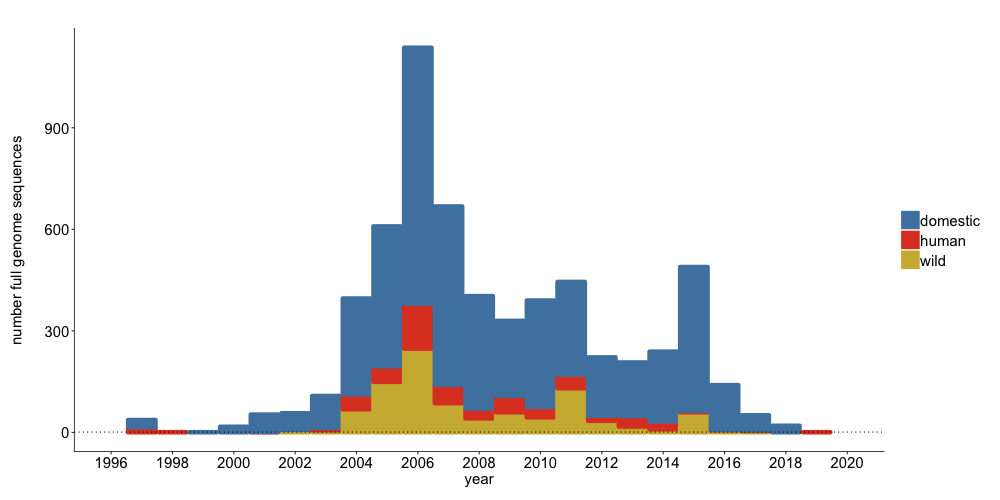

In [54]:
%%R -w 1000 -h 500 -u px -i df,output_directory  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

df$date = as.Date(df$date)
df$year = as.numeric(df$year)
p <- ggplot(data=df, aes(x=year, group=domestic_wild, color=domestic_wild, fill=domestic_wild)) + 
    geom_histogram(stat="count", size=2)+
    geom_hline(yintercept=1, linetype = 3)+
    #geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x="year",y="number full genome sequences")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_colour_manual(values=c(domestic="#4E83AE",wild="#CEB540", human="#DE4428"))+
    scale_fill_manual(values=c(domestic="#4E83AE",wild="#CEB540", human="#DE4428"))+
    #scale_y_continuous(limits=c(0,275), breaks=seq(0,275,25))+
    scale_x_continuous(limits=c(1996,2020), breaks=seq(0,2020,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=15))+
    theme(axis.title.y=element_text(size=15, vjust=8))+
    theme(axis.title.x=element_text(size=15))+
    theme(axis.text=element_text(size=15, colour="black"))+
    theme(legend.text=element_text(size=15))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1.0,0.5,0.5,1.0),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("available-seqs-per-year-host-2022-06-16.pdf", p, width = 12, height = 5, path=output_directory)
p

In [55]:
def group_into_continents(region):
    if "Asia" in region or "China" in region or "Japan Korea" in region: 
        continent = "Asia"
    elif "America" in region: 
        continent = "Americas"
    else:
        continent = region
    return(continent)

In [56]:
df['continent'] = df['region'].apply(group_into_continents)
df.head()

,index,date,region,country,domestic_wild,host_group,annotation_method,year,continent
0,A/Alberta/1/2014,2014-01-03,North America,Canada,human,human,,2014,Americas
1,A/American_green_winged_teal/Washington/195750...,2014-12-29,North America,USA,wild,avian,species name,2014,Americas
2,A/American_wigeon/Washington/196336/2015,2015-01-02,North America,USA,wild,avian,species name,2015,Americas
3,A/American_wigeon/Washington/196340/2015,2015-01-02,North America,USA,wild,avian,species name,2015,Americas
4,A/Americanblackduck/Alberta/118/2016,2016-08-11,North America,Canada,wild,avian,species name,2016,Americas


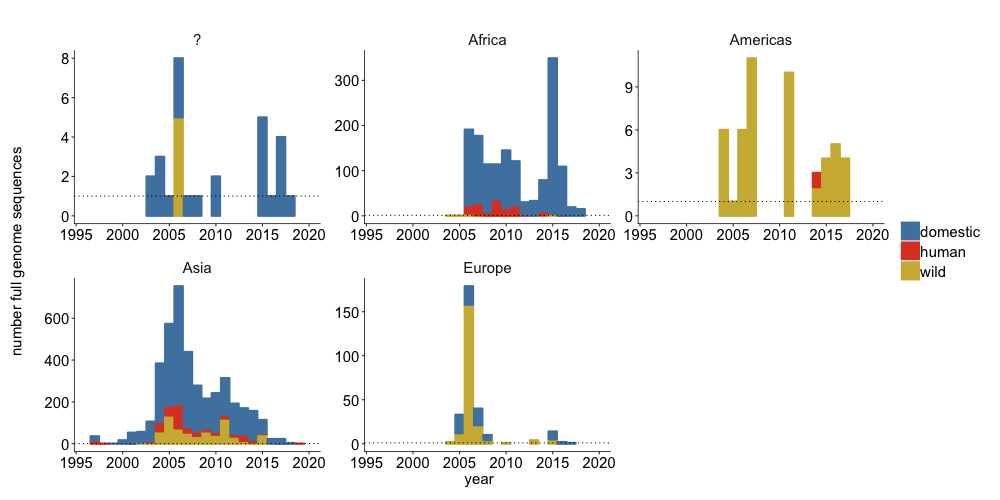

In [57]:
%%R -w 1000 -h 500 -u px -i df,output_directory  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

df$date = as.Date(df$date)
df$year = as.numeric(df$year)

p <- ggplot(data=df, aes(x=year, group=domestic_wild, color=domestic_wild, fill=domestic_wild)) + 
    geom_histogram(stat="count", size=1)+
    geom_hline(yintercept=1, linetype = 3)+
    facet_wrap(~continent, scales="free")+
    #geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x="year",y="number full genome sequences")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_colour_manual(values=c(domestic="#4E83AE",wild="#CEB540", human="#DE4428"))+
    scale_fill_manual(values=c(domestic="#4E83AE",wild="#CEB540", human="#DE4428"))+
    ##scale_y_continuous(limits=c(0,275), breaks=seq(0,275,25))+
    scale_x_continuous(limits=c(1996,2020), breaks=seq(0,2020,5))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=15))+
    theme(axis.title.y=element_text(size=15, vjust=8))+
    theme(axis.title.x=element_text(size=15))+
    theme(axis.text=element_text(size=15, colour="black"))+
    theme(legend.text=element_text(size=15))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1.0,0.5,0.5,1.0),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("available-seqs-per-year-continent-host-2022-06-15.pdf", p, width = 16, height = 8, path=output_directory)
p

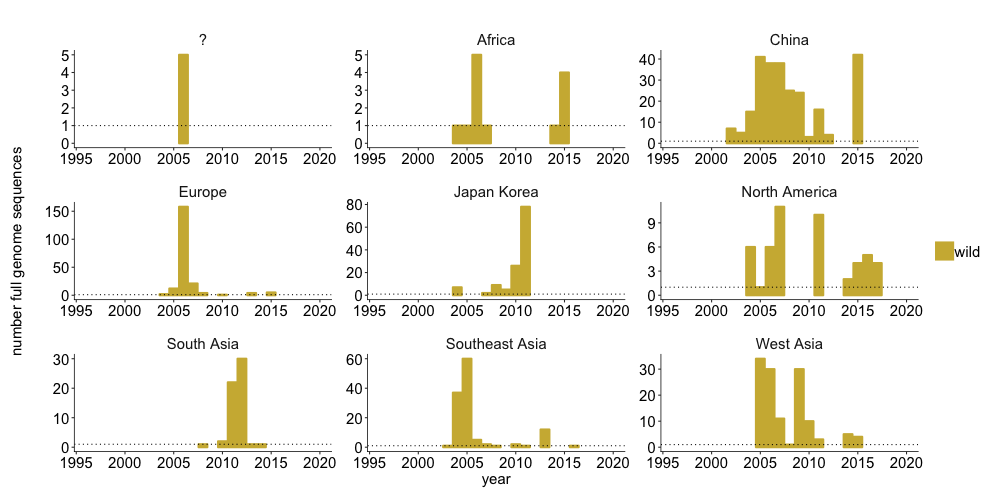

In [63]:
%%R -w 1000 -h 500 -u px -i df,output_directory  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

df$date = as.Date(df$date)
df$year = as.numeric(df$year)

df <- subset(df, df$domestic_wild=="wild",)

p <- ggplot(data=df, aes(x=year, group=domestic_wild, color=domestic_wild, fill=domestic_wild)) + 
    geom_histogram(stat="count", size=1)+
    #geom_vline(xintercept=2002, linetype = 3)+
    geom_hline(yintercept=1, linetype = 3)+
    facet_wrap(~region, scales="free")+
    #geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x="year",y="number full genome sequences")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    scale_colour_manual(values=c(domestic="#4E83AE",wild="#CEB540", human="#DE4428"))+
    scale_fill_manual(values=c(domestic="#4E83AE",wild="#CEB540", human="#DE4428"))+
    ##scale_y_continuous(limits=c(0,275), breaks=seq(0,275,25))+
    scale_x_continuous(limits=c(1996,2020), breaks=seq(0,2020,5))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=15))+
    theme(axis.title.y=element_text(size=15, vjust=8))+
    theme(axis.title.x=element_text(size=15))+
    theme(axis.text=element_text(size=15, colour="black"))+
    theme(legend.text=element_text(size=15))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1.0,0.5,0.5,1.0),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("available-seqs-per-year-region-host-2022-06-15.pdf", p, width = 16, height = 8, path=output_directory)
p

In [25]:
df[df['year']=="1996"]

,index,date,region,country,domestic_wild,host_group,annotation_method,year
689,A/Goose/Guangdong/1/1996,1996-XX-XX,China,China,domestic,avian,manual curation,1996
6864,A/goose/Guangdong/1/1996,1996-XX-XX,China,China,domestic,avian,manual curation,1996


In [26]:
df[df['year']=="1997"]

,index,date,region,country,domestic_wild,host_group,annotation_method,year
135,A/Chicken/HongKong/1203/1997,1997-XX-XX,China,Hong Kong,domestic,avian,species name,1997
136,A/Chicken/HongKong/220/1997,1997-XX-XX,China,Hong Kong,domestic,avian,species name,1997
139,A/Chicken/HongKong/728/1997,1997-XX-XX,China,Hong Kong,domestic,avian,species name,1997
140,A/Chicken/HongKong/786/1997,1997-XX-XX,China,Hong Kong,domestic,avian,species name,1997
151,A/Chicken/HongKong/976/1997,1997-XX-XX,China,Hong Kong,domestic,avian,species name,1997
159,A/Chicken/HongKong/y385/1997,1997-XX-XX,China,Hong Kong,domestic,avian,species name,1997
160,A/Chicken/HongKong/y388/1997,1997-XX-XX,China,Hong Kong,domestic,avian,species name,1997
444,A/Duck/HongKong/p46/1997,1997-XX-XX,China,Hong Kong,domestic,avian,manual curation,1997
449,A/Duck/HongKong/y283/1997,1997-XX-XX,China,Hong Kong,domestic,avian,manual curation,1997
695,A/Goose/HongKong/w355/1997,1997-XX-XX,China,Hong Kong,domestic,avian,manual curation,1997


In [27]:
df[df['year']=="1998"]

,index,date,region,country,domestic_wild,host_group,annotation_method,year
750,A/HongKong/97/1998,1998-XX-XX,China,Hong Kong,human,human,,1998


In [28]:
df[df['year']=="1999"]

,index,date,region,country,domestic_wild,host_group,annotation_method,year
5271,A/duck/Guangxi/07/1999,1999-XX-XX,China,China,domestic,avian,manual curation,1999


In [29]:
df[df['year']=="2000"]

,index,date,region,country,domestic_wild,host_group,annotation_method,year
440,A/Duck/HongKong/29861/2000,2000-XX-XX,China,Hong Kong,domestic,avian,manual curation,2000
445,A/Duck/HongKong/ww381/2000,2000-XX-XX,China,Hong Kong,domestic,avian,manual curation,2000
446,A/Duck/HongKong/ww382/2000,2000-XX-XX,China,Hong Kong,domestic,avian,manual curation,2000
447,A/Duck/HongKong/ww461/2000,2000-XX-XX,China,Hong Kong,domestic,avian,manual curation,2000
448,A/Duck/HongKong/ww487/2000,2000-XX-XX,China,Hong Kong,domestic,avian,manual curation,2000
691,A/Goose/HongKong/30148/2000,2000-XX-XX,China,Hong Kong,domestic,avian,manual curation,2000
692,A/Goose/HongKong/3853/2000,2000-XX-XX,China,Hong Kong,domestic,avian,manual curation,2000
693,A/Goose/HongKong/3855/2000,2000-XX-XX,China,Hong Kong,domestic,avian,manual curation,2000
697,A/Goose/HongKong/ww26/2000,2000-XX-XX,China,Hong Kong,domestic,avian,manual curation,2000
698,A/Goose/HongKong/ww28/2000,2000-XX-XX,China,Hong Kong,domestic,avian,manual curation,2000


In [30]:
df[df['year']=="2001"]

,index,date,region,country,domestic_wild,host_group,annotation_method,year
137,A/Chicken/HongKong/3175/2001,2001-XX-XX,China,Hong Kong,domestic,avian,species name,2001
138,A/Chicken/HongKong/7155/2001,2001-XX-XX,China,Hong Kong,domestic,avian,species name,2001
141,A/Chicken/HongKong/8221/2001,2001-XX-XX,China,Hong Kong,domestic,avian,species name,2001
142,A/Chicken/HongKong/8292/2001,2001-XX-XX,China,Hong Kong,domestic,avian,species name,2001
143,A/Chicken/HongKong/8302/2001,2001-XX-XX,China,Hong Kong,domestic,avian,species name,2001
144,A/Chicken/HongKong/8583/2001,2001-XX-XX,China,Hong Kong,domestic,avian,species name,2001
145,A/Chicken/HongKong/8671/2001,2001-XX-XX,China,Hong Kong,domestic,avian,species name,2001
146,A/Chicken/HongKong/8733/2001,2001-XX-XX,China,Hong Kong,domestic,avian,species name,2001
147,A/Chicken/HongKong/8761/2001,2001-XX-XX,China,Hong Kong,domestic,avian,species name,2001
148,A/Chicken/HongKong/8791/2001,2001-XX-XX,China,Hong Kong,domestic,avian,species name,2001


In [31]:
df[df['year']=="2002"]

,index,date,region,country,domestic_wild,host_group,annotation_method,year
342,A/Ck/HongKong/312/2002,2002-XX-XX,China,Hong Kong,domestic,avian,manual curation,2002
344,A/Ck/HongKong/31691/2002,2002-XX-XX,China,Hong Kong,domestic,avian,manual curation,2002
345,A/Ck/HongKong/31763/2002,2002-XX-XX,China,Hong Kong,domestic,avian,manual curation,2002
346,A/Ck/HongKong/374/2002,2002-XX-XX,China,Hong Kong,domestic,avian,manual curation,2002
354,A/Ck/HongKong/YU22/2002,2002-XX-XX,China,Hong Kong,domestic,avian,manual curation,2002
489,A/Eg/HongKong/7573/2002,2002-XX-XX,China,Hong Kong,domestic,avian,species name,2002
688,A/Gf/HongKong/38/2002,2002-XX-XX,China,Hong Kong,domestic,avian,manual curation,2002
1061,A/SCk/HongKong/YU100/2002,2002-XX-XX,China,Hong Kong,domestic,avian,species name,2002
1748,A/chicken/China/1/2002,2002-XX-XX,China,China,domestic,avian,species name,2002
2673,A/chicken/Hebei/108/2002,2002-XX-XX,China,China,domestic,avian,species name,2002


In [32]:
df[df['year']=="2003"]

,index,date,region,country,domestic_wild,host_group,annotation_method,year
41,A/Beijing/1/2003,2003-XX-XX,China,China,human,human,,2003
198,A/Chicken/Legok/2003,2003-XX-XX,Southeast Asia,Indonesia,domestic,avian,species name,2003
321,A/Chicken/WestJava/2003,2003-XX-XX,Southeast Asia,Indonesia,domestic,avian,species name,2003
341,A/Ck/HongKong/21331/2003,2003-XX-XX,China,Hong Kong,domestic,avian,manual curation,2003
350,A/Ck/HongKong/FY157/2003,2003-XX-XX,China,Hong Kong,domestic,avian,manual curation,2003
351,A/Ck/HongKong/NT93/2003,2003-XX-XX,China,Hong Kong,domestic,avian,manual curation,2003
352,A/Ck/HongKong/SSP141/2003,2003-XX-XX,China,Hong Kong,domestic,avian,manual curation,2003
353,A/Ck/HongKong/WF157/2003,2003-XX-XX,China,Hong Kong,domestic,avian,manual curation,2003
355,A/Ck/HongKong/YU324/2003,2003-XX-XX,China,Hong Kong,domestic,avian,manual curation,2003
357,A/Ck/Indonesia/2A/2003,2003-XX-XX,Southeast Asia,Indonesia,domestic,avian,manual curation,2003


In [35]:
df[df['year']=="2004"]

,index,date,region,country,domestic_wild,host_group,annotation_method,year
113,A/Chick/Macheng/2004,2004-XX-XX,China,China,domestic,avian,species name,2004
115,A/Chicken/Anhui/39/2004,2004-XX-XX,China,China,domestic,avian,species name,2004
118,A/Chicken/Ayutthaya/Thailand/CU-23/2004,2004-XX-XX,Southeast Asia,Thailand,domestic,avian,species name,2004
129,A/Chicken/Guangdong/174/2004,2004-XX-XX,China,China,domestic,avian,species name,2004
131,A/Chicken/Henan/12/2004,2004-XX-XX,China,China,domestic,avian,species name,2004
132,A/Chicken/Henan/13/2004,2004-XX-XX,China,China,domestic,avian,species name,2004
133,A/Chicken/Henan/16/2004,2004-XX-XX,China,China,domestic,avian,species name,2004
134,A/Chicken/Henan/210/2004,2004-XX-XX,China,China,domestic,avian,species name,2004
183,A/Chicken/Jiangxi/25/2004,2004-XX-XX,China,China,domestic,avian,species name,2004
184,A/Chicken/Kamphaengphet-2-01/2004,2004-XX-XX,Southeast Asia,Thailand,domestic,avian,species name,2004


In [34]:
df[df['year']=="2005"]

,index,date,region,country,domestic_wild,host_group,annotation_method,year
11,A/Anhui/1/2005,2005-11-08,China,China,human,human,,2005
14,A/Anhui/2/2005,2005-XX-XX,China,China,human,human,,2005
28,A/Bar-headedGoose/Qinghai/12/2005,2005-XX-XX,China,China,wild,avian,species name,2005
29,A/Bar-headedGoose/Qinghai/5/2005,2005-XX-XX,China,China,wild,avian,species name,2005
30,A/Bar-headedGoose/Qinghai/59/2005,2005-XX-XX,China,China,wild,avian,species name,2005
31,A/Bar-headedGoose/Qinghai/60/2005,2005-XX-XX,China,China,wild,avian,species name,2005
32,A/Bar-headedGoose/Qinghai/61/2005,2005-XX-XX,China,China,wild,avian,species name,2005
33,A/Bar-headedGoose/Qinghai/62/2005,2005-XX-XX,China,China,wild,avian,species name,2005
34,A/Bar-headedGoose/Qinghai/65/2005,2005-XX-XX,China,China,wild,avian,species name,2005
35,A/Bar-headedGoose/Qinghai/67/2005,2005-XX-XX,China,China,wild,avian,species name,2005


In [61]:
print(len(df[(df['domestic_wild']=='wild')&(df['region']=='Southeast Asia')]))
print(df[(df['domestic_wild']=='wild')&(df['region']=='Southeast Asia')]['year'].value_counts())
df[(df['domestic_wild']=='wild')&(df['region']=='Southeast Asia')]

122
2005    60
2004    37
2013    12
2006     5
2007     2
2010     2
2011     1
2016     1
2003     1
2008     1
Name: year, dtype: int64


,index,date,region,country,domestic_wild,host_group,annotation_method,year,continent
915,A/Littlecuckoo-Dove/Tak-2-01/2004,2004-XX-XX,Southeast Asia,Thailand,wild,avian,species name,2004,Asia
1014,A/Mynas/Ranong/Thailand/CU-209/2004,2004-XX-XX,Southeast Asia,Thailand,wild,avian,species name,2004,Asia
1018,A/Openbillstork/Thailand/VSMU-16-AYA/2004,2004-XX-XX,Southeast Asia,Thailand,wild,avian,species name,2004,Asia
1019,A/Openbillstork/Thailand/VSMU-6-BKK/2004,2004-XX-XX,Southeast Asia,Thailand,wild,avian,species name,2004,Asia
1076,A/Swiftlet/Vietnam/NCVD-3000/2013,2013-04-04,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
1077,A/Swiftlet/Vietnam/NCVD_3000/2013,2013-04-04,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
1318,A/brown-headedgull/Thailand/VSMU-28-SPK/2005,2005-XX-XX,Southeast Asia,Thailand,wild,avian,species name,2005,Asia
1319,A/brown-headgull/Thailand/vsmu-4/2008,2008-XX-XX,Southeast Asia,Thailand,wild,avian,species name,2008,Asia
4635,A/commonmyna/Thailand/VSMU-10-BRM/2005,2005-XX-XX,Southeast Asia,Thailand,wild,avian,species name,2005,Asia
4660,A/crow/Bangkok/Thailand/CU-15/2004,2004-XX-XX,Southeast Asia,Thailand,wild,avian,species name,2004,Asia


In [84]:
df[(df['domestic_wild']=='wild')&(df['country']=='Vietnam')]

,index,date,region,country,domestic_wild,host_group,annotation_method,year,continent
1076,A/Swiftlet/Vietnam/NCVD-3000/2013,2013-04-04,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
1077,A/Swiftlet/Vietnam/NCVD_3000/2013,2013-04-04,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
7830,A/swallow/NinhThuan/AI023/2013,2013-04-04,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
7831,A/swallow/NinhThuan/AI026/2013,2013-04-09,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
7832,A/swallow/NinhThuan/AI027/2013,2013-04-10,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
7833,A/swallow/NinhThuan/AI028/2013,2013-04-11,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
7834,A/swallow/NinhThuan/AI032/2013,2013-04-13,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
7835,A/swallow/NinhThuan/AI034/2013,2013-04-15,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
7836,A/swallow/NinhThuan/AI037/2013,2013-04-18,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia
7837,A/swallow/Vietnam/NT22/2013,2013-04-07,Southeast Asia,Vietnam,wild,avian,species name,2013,Asia


In [82]:
df[(df['domestic_wild']=='wild')&(df['country']=='Vietnam')&(df['year']=='2015')]

,index,date,region,country,domestic_wild,host_group,annotation_method,year,continent
38,A/Bar-headedGoose/Qinghai/BTY2/2015,2015-07-14,China,China,wild,avian,species name,2015,Asia
43,A/Black-neckedGrebe/InnerMongolia/Analswab4/2015,2015-05-12,China,China,wild,avian,species name,2015,Asia
44,A/Black-neckedGrebe/InnerMongolia/Brain1/2015,2015-05-12,China,China,wild,avian,species name,2015,Asia
45,A/Black-neckedGrebe/InnerMongolia/Brain2/2015,2015-05-12,China,China,wild,avian,species name,2015,Asia
46,A/Black-neckedGrebe/InnerMongolia/Brain3/2015,2015-05-12,China,China,wild,avian,species name,2015,Asia
47,A/Black-neckedGrebe/InnerMongolia/Liver3/2015,2015-05-12,China,China,wild,avian,species name,2015,Asia
48,A/Black-neckedGrebe/InnerMongolia/Lung2/2015,2015-05-12,China,China,wild,avian,species name,2015,Asia
49,A/Black-neckedGrebe/InnerMongolia/Lung3-2/2015,2015-05-12,China,China,wild,avian,species name,2015,Asia
50,A/Black-neckedGrebe/InnerMongolia/Lung3/2015,2015-05-12,China,China,wild,avian,species name,2015,Asia
51,A/Black-neckedGrebe/InnerMongolia/Oropharynxsw...,2015-05-12,China,China,wild,avian,species name,2015,Asia


In [27]:
dates_df

,index,total,day,month,year
0,2014,137,127.0,10.0,0.0
1,2016,95,92.0,2.0,1.0
2,2015,271,258.0,10.0,3.0
3,2008,206,81.0,46.0,79.0
4,2006,397,172.0,9.0,216.0
5,2005,303,37.0,0.0,266.0
6,2007,360,96.0,42.0,222.0
7,2017,53,52.0,1.0,0.0
8,2011,251,186.0,53.0,12.0
9,2003,94,10.0,0.0,84.0


In [28]:
dates_df_melt = dates_df.melt(id_vars=['index','total'])
dates_df_melt.head()

,index,total,variable,value
0,2014,137,day,127.0
1,2016,95,day,92.0
2,2015,271,day,258.0
3,2008,206,day,81.0
4,2006,397,day,172.0


In [35]:
output_directory = "/Users/lmoncla/src/h5n1-host-classification/figures"

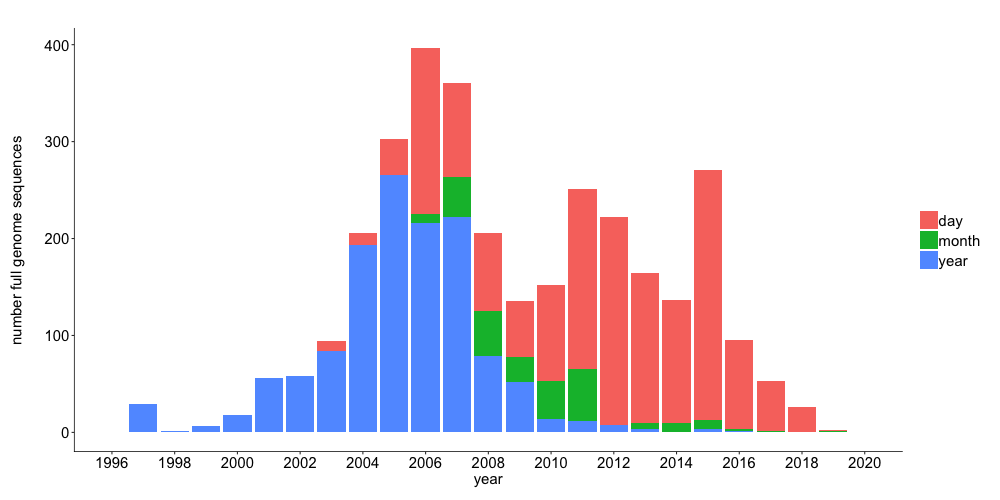

In [29]:
%%R -w 1000 -h 500 -u px -i dates_df_melt,output_directory  # this sets the size of the plot...otherwise, it will go off the page
require(ggplot2)
library(ggplot2)

dates_df_melt$index = as.numeric(dates_df_melt$index)

p <- ggplot(data=dates_df_melt, aes(x=index, y=value, fill=variable)) + 
    geom_col()+
    #geom_vline(xintercept=vlines1, size=0.8, linetype='dashed', color = '#808080')+
    labs(x="year",y="number full genome sequences")+
    theme(plot.title = element_text(size=20, hjust=0.5))+
    #scale_colour_manual(values=c("#4C9C86","#271B9C"), guide=FALSE)+
    #scale_y_continuous(limits=c(0,275), breaks=seq(0,275,25))+
    scale_x_continuous(limits=c(1996,2020), breaks=seq(0,2020,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(strip.text.x=element_text(size=15))+
    theme(axis.title.y=element_text(size=15, vjust=8))+
    theme(axis.title.x=element_text(size=15))+
    theme(axis.text=element_text(size=15, colour="black"))+
    theme(legend.text=element_text(size=15))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1.0,0.5,0.5,1.0),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))

ggsave("available-seqs-per-year-date-resolution-2022-06-15.pdf", p, width = 12, height = 5, path=output_directory)
p

In [30]:
# get tthe number of genomes with date resolutions partitioned by host group 

dates_with_host = return_dates_and_host(all_full_genomes_dict)
dates_with_host

{'human': {2014: {'day': 11},
  2005: {'day': 16, 'year': 14},
  2006: {'day': 70, 'year': 15},
  2007: {'day': 25, 'year': 3},
  2008: {'month': 3, 'day': 19, 'year': 2},
  2011: {'day': 17, 'year': 10},
  2003: {'year': 3, 'day': 4},
  2010: {'day': 17},
  2012: {'day': 8},
  2013: {'day': 18},
  2009: {'day': 12, 'year': 1},
  2015: {'day': 2},
  1997: {'year': 15},
  2001: {'year': 1},
  1998: {'year': 1},
  2019: {'day': 1},
  2004: {'year': 20, 'day': 6}},
 'domestic': {2004: {'year': 145, 'day': 5},
  2013: {'day': 60, 'month': 7, 'year': 2},
  2005: {'year': 198, 'day': 10},
  1997: {'year': 14},
  2001: {'year': 49},
  2006: {'year': 161, 'day': 69, 'month': 4},
  2009: {'day': 26, 'month': 18, 'year': 15},
  2007: {'month': 10, 'year': 169, 'day': 67},
  2008: {'day': 65, 'year': 43, 'month': 18},
  2003: {'year': 73, 'day': 3},
  2002: {'year': 44},
  2000: {'year': 15},
  1996: {'year': 1},
  2011: {'month': 41, 'day': 82, 'year': 2},
  2014: {'day': 98, 'month': 9},
  2015

In [31]:
date_resolution_df = pd.DataFrame.from_dict(dates_with_host, orient="columns")
date_resolution_df = date_resolution_df.fillna(0)
date_resolution_df.reset_index(inplace=True)
date_resolution_df

,index,human,domestic,wild
0,2014,{'day': 11},"{'day': 98, 'month': 9}","{'day': 6, 'month': 1}"
1,2005,"{'day': 16, 'year': 14}","{'year': 198, 'day': 10}","{'year': 73, 'day': 7}"
2,2006,"{'day': 70, 'year': 15}","{'year': 161, 'day': 69, 'month': 4}","{'day': 27, 'year': 41, 'month': 1}"
3,2007,"{'day': 25, 'year': 3}","{'month': 10, 'year': 169, 'day': 67}","{'day': 12, 'year': 30, 'month': 2}"
4,2008,"{'month': 3, 'day': 19, 'year': 2}","{'day': 65, 'year': 43, 'month': 18}","{'year': 13, 'month': 2}"
5,2011,"{'day': 17, 'year': 10}","{'month': 41, 'day': 82, 'year': 2}","{'month': 29, 'day': 44, 'year': 1}"
6,2003,"{'year': 3, 'day': 4}","{'year': 73, 'day': 3}","{'year': 4, 'day': 2}"
7,2010,{'day': 17},"{'day': 61, 'year': 12, 'month': 45}","{'day': 9, 'month': 4, 'year': 6}"
8,2012,{'day': 8},{'day': 118},"{'day': 16, 'month': 1}"
9,2013,{'day': 18},"{'day': 60, 'month': 7, 'year': 2}",{'day': 10}


## Look at representation of hosts by clade 

In [76]:
wild_by_clade = {}

for f in all_full_genomes_dict_deduped:
    if all_full_genomes_dict_deduped[f]['domestic_wild'] == "wild": 
        clade_group = all_full_genomes_dict_deduped[f]['clade_group']
        date = all_full_genomes_dict_deduped[f]['date']
        
        if clade_group not in wild_by_clade: 
            wild_by_clade[clade_group] = {"count":1, "dates":[date]}
        else: 
            wild_by_clade[clade_group]["count"] += 1
            wild_by_clade[clade_group]["dates"].append(date)
            

In [79]:
for clade in wild_by_clade:
    print("\n\n",clade)
    print(wild_by_clade[clade]['count'])
    print(wild_by_clade[clade]['dates'])
    print(set(wild_by_clade[clade]['dates']))



 non-GsGd
27
['2016-08-11', '2017-01-13', '2016-09-17', '2004-XX-XX', '2017-01-14', '2011-08-12', '2011-08-12', '2011-08-12', '2011-08-12', '2015-02-19', '2009-XX-XX', '2006-XX-XX', '2006-XX-XX', '2011-12-08', '2007-XX-XX', '2007-05-22', '2007-05-22', '2007-07-26', '2007-08-10', '2007-05-23', '2007-05-24', '2005-11-25', '2009-09-XX', '2009-09-27', '2004-XX-XX', '2004-XX-XX', '2004-XX-XX']
{'2007-05-22', '2011-08-12', '2007-08-10', '2007-05-24', '2011-12-08', '2009-XX-XX', '2004-XX-XX', '2007-07-26', '2009-09-27', '2007-05-23', '2015-02-19', '2017-01-14', '2016-09-17', '2009-09-XX', '2017-01-13', '2005-11-25', '2007-XX-XX', '2006-XX-XX', '2016-08-11'}


 2.3.4
22
['2014-12-29', '2015-01-02', '2015-01-02', '2005-XX-XX', '2006-XX-XX', '2007-XX-XX', '2006-XX-XX', '2006-XX-XX', '2007-XX-XX', '2006-XX-XX', '2006-XX-XX', '2007-01-10', '2007-XX-XX', '2008-XX-XX', '2007-XX-XX', '2007-XX-XX', '2006-XX-XX', '2008-XX-XX', '2005-11-01', '2005-XX-XX', '2005-XX-XX', '2011-04-14']
{'2007-01-10', '20

In [84]:
wild_by_region = {}

for f in all_full_genomes_dict_deduped:
    if all_full_genomes_dict_deduped[f]['domestic_wild'] == "wild": 
        region = all_full_genomes_dict_deduped[f]['region']
        date = all_full_genomes_dict_deduped[f]['date']
        
        if region not in wild_by_region: 
            wild_by_region[region] = {"count":1, "dates":[date]}
        else: 
            wild_by_region[region]["count"] += 1
            wild_by_region[region]["dates"].append(date)
            

In [85]:
for region in wild_by_region:
    print("\n\n",region)
    print(wild_by_region[region]['count'])
    print(wild_by_region[region]['dates'])
    print(set(wild_by_region[region]['dates']))



 North America
23
['2016-08-11', '2014-12-29', '2015-01-02', '2015-01-02', '2017-01-13', '2016-09-17', '2017-01-14', '2011-08-12', '2011-08-12', '2011-08-12', '2011-08-12', '2006-XX-XX', '2011-12-08', '2007-XX-XX', '2007-05-22', '2007-05-22', '2007-07-26', '2007-08-10', '2007-05-23', '2007-05-24', '2004-XX-XX', '2004-XX-XX', '2004-XX-XX']
{'2007-05-22', '2004-XX-XX', '2017-01-13', '2007-07-26', '2011-08-12', '2007-08-10', '2015-01-02', '2011-12-08', '2007-05-23', '2007-XX-XX', '2007-05-24', '2014-12-29', '2017-01-14', '2006-XX-XX', '2016-08-11', '2016-09-17'}


 China
105
['2005-XX-XX', '2005-XX-XX', '2005-XX-XX', '2015-07-14', '2015-05-12', '2015-05-12', '2005-XX-XX', '2005-XX-XX', '2007-XX-XX', '2005-XX-XX', '2005-XX-XX', '2005-XX-XX', '2015-07-14', '2015-07-14', '2006-XX-XX', '2012-07-12', '2015-01-09', '2015-01-09', '2005-XX-XX', '2004-XX-XX', '2005-XX-XX', '2006-XX-XX', '2005-XX-XX', '2006-XX-XX', '2007-09-XX', '2006-XX-XX', '2015-07-XX', '2015-07-XX', '2008-XX-XX', '2005-XX-XX'